# 05_Naive_Bayess

En teoría de la probabilidad y minería de datos, un clasificador Naive Bayes es un clasificador probabilístico fundamentado en el teorema de Bayes y algunas hipótesis simplificadoras adicionales.

¿me conviene comprar casa ó alquilar?

Instalamos anaconda 
 -Proporciona una interfaz de alto nivel para dibujar gráficos estadísticos atractivos.

In [1]:
!conda install -c anaconda seaborn -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



## Importamos:

    -panda: extensión de NumPy para manipulación y análisis de datos para el lenguaje de programación Python
    -numpy: extensión de Python, que le agrega mayor soporte para vectores y matrices
    -matplotlib.pyplot: es una colección de funciones que hacen que matplotlib funcione como MATLAB. Cada pyplotfunción realiza algún cambio en una figura
    -seaborn: Proporciona una interfaz de alto nivel para dibujar gráficos estadísticos atractivos e informativos
    -Scikit-learn es una biblioteca de software de aprendizaje automático para el lenguaje de programación Python

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest

Importamos los datos de un CSV y luego la visualizamos 

In [4]:
dataframe = pd.read_csv(r'comprar_alquilar.csv')
dataframe.head(10)

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1
7,6470,1035,39,782,57439,606291,0,0,1,0
8,6251,1250,209,571,50503,291010,0,0,3,1
9,6987,1258,252,245,40611,324098,2,1,7,1


Veamos qué cantidad de muestras de comprar o alquilar tenemos:

In [5]:
print(dataframe.groupby('comprar').size())

comprar
0    135
1     67
dtype: int64


Hagamos un histograma de las características quitando la columna de resultados (comprar):

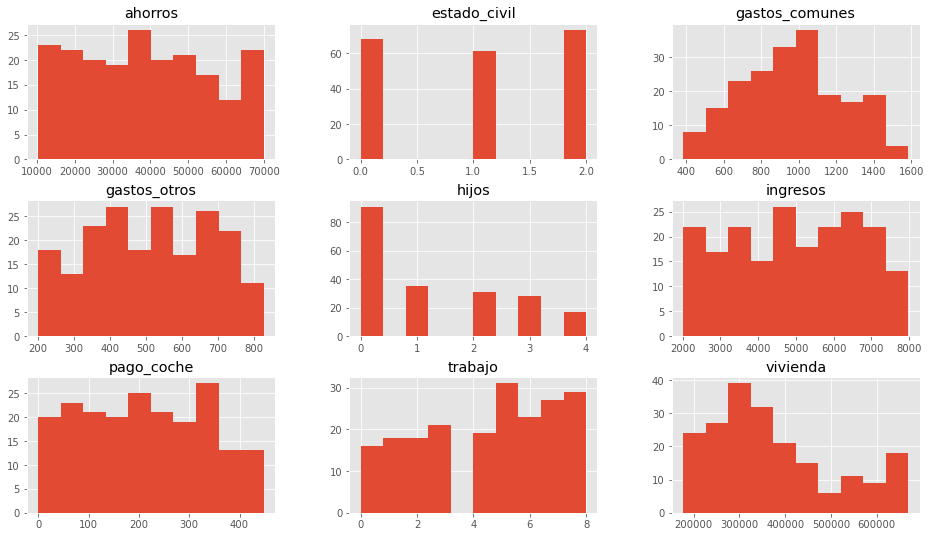

In [6]:
dataframe.drop(['comprar'], axis=1).hist()
plt.show()

Vamos a hacer algo: procesemos algunas de estas columnas. Por ejemplo, podríamos agrupar los diversos gastos. También crearemos una columna llamada financiar que será la resta del precio de la vivienda con los ahorros de la familia.

In [7]:
dataframe['gastos']=(dataframe['gastos_comunes']+dataframe['gastos_otros']+dataframe['pago_coche'])
dataframe['financiar']=dataframe['vivienda']-dataframe['ahorros']
dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1).head(10)

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
0,6000,50000,400000,0,2,2,1,1600,350000
1,6745,43240,636897,1,3,6,0,1496,593657
2,6455,57463,321779,2,1,8,1,1926,264316
3,7098,54506,660933,0,0,3,0,1547,606427
4,6167,41512,348932,0,0,3,1,1606,307420
5,5692,50875,360863,1,4,5,1,1247,309988
6,6830,46761,429812,1,1,5,1,1952,383051
7,6470,57439,606291,0,0,1,0,1856,548852
8,6251,50503,291010,0,0,3,1,2030,240507
9,6987,40611,324098,2,1,7,1,1755,283487


Y ahora veamos un resumen estadístico que nos brinda la librería Pandas con describe():

In [8]:
reduced = dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1)
reduced.describe()

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,4958.995050,38749.668317,373349.638614,1.024752,1.232673,4.490099,0.331683,1698.752475,334599.970297
std,1682.862556,17365.231870,136371.525622,0.837184,1.367833,2.535794,0.471988,324.838005,126607.099497
min,2008.000000,10319.000000,176553.000000,0.000000,0.000000,0.000000,0.000000,1007.000000,154716.000000
25%,3513.750000,24964.250000,274810.000000,0.000000,0.000000,2.000000,0.000000,1430.500000,240410.250000
50%,4947.500000,38523.000000,340783.500000,1.000000,1.000000,5.000000,0.000000,1669.500000,301177.000000
75%,6374.500000,52150.750000,444482.000000,2.000000,2.000000,7.000000,1.000000,1928.000000,393413.000000
max,7984.000000,69934.000000,669540.000000,2.000000,4.000000,8.000000,1.000000,2543.000000,618621.000000


En este ejercicio haremos Feature Selection para mejorar nuestros resultados con este algoritmo. En vez de utilizar las 11 columnas de datos de entrada que tenemos, vamos a utilizar una Clase de SkLearn llamada SelectKBest con la que seleccionaremos las 5 mejores características y usaremos sólo esas.

In [9]:
X=dataframe.drop(['comprar'], axis=1)
y=dataframe['comprar']

best=SelectKBest(k=5)
X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar'], dtype='object')


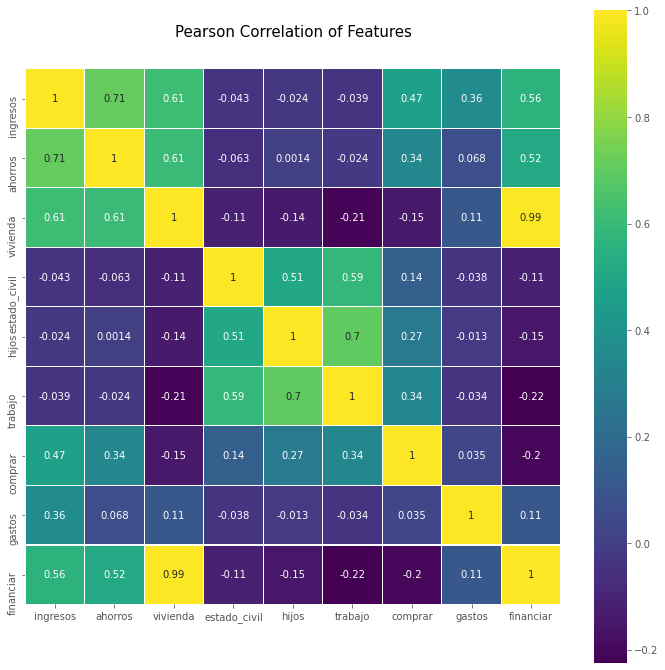

In [10]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(reduced.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Bien, entonces usaremos 5 de las 11 características que teníamos. Las que “más aportan” al momento de clasificar. Veamos qué grado de correlación tienen:

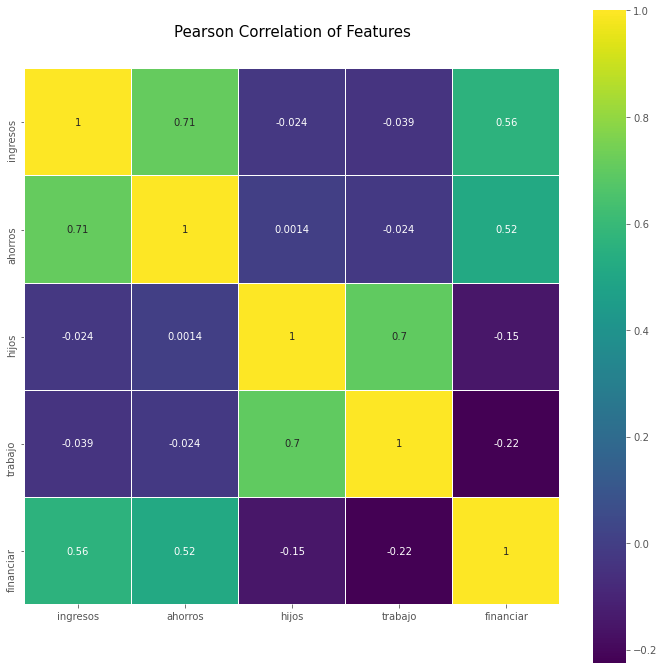

In [13]:
used_features =X.columns[selected]

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(dataframe[used_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

## Crear el modelo Gaussian Naive Bayes con SKLearn

-Primero vamos a dividir nuestros datos de entrada en entrenamiento y test.

In [14]:
# Split dataset in training and test datasets
X_train, X_test = train_test_split(dataframe, test_size=0.2, random_state=6) 
y_train =X_train["comprar"]
y_test = X_test["comprar"]

Y creamos el modelo, lo ponemos a aprender con fit() y obtenemos predicciones sobre nuestro conjunto de test.

In [15]:
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train[used_features].values,
    y_train
)
y_pred = gnb.predict(X_test[used_features])

print('Precisión en el set de Entrenamiento: {:.2f}'
     .format(gnb.score(X_train[used_features], y_train)))
print('Precisión en el set de Test: {:.2f}'
     .format(gnb.score(X_test[used_features], y_test)))

Precisión en el set de Entrenamiento: 0.87
Precisión en el set de Test: 0.90


## Probemos el modelo: ¿Comprar o Alquilar?

In [16]:
#                 ['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar']
print(gnb.predict([[2000,        5000,     0,       5,         200000],
                   [6000,        34000,    2,       5,         320000] ]))
#Resultado esperado 0-Alquilar, 1-Comprar casa

[0 1]


/srv/conda/envs/notebook/lib/python3.6/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


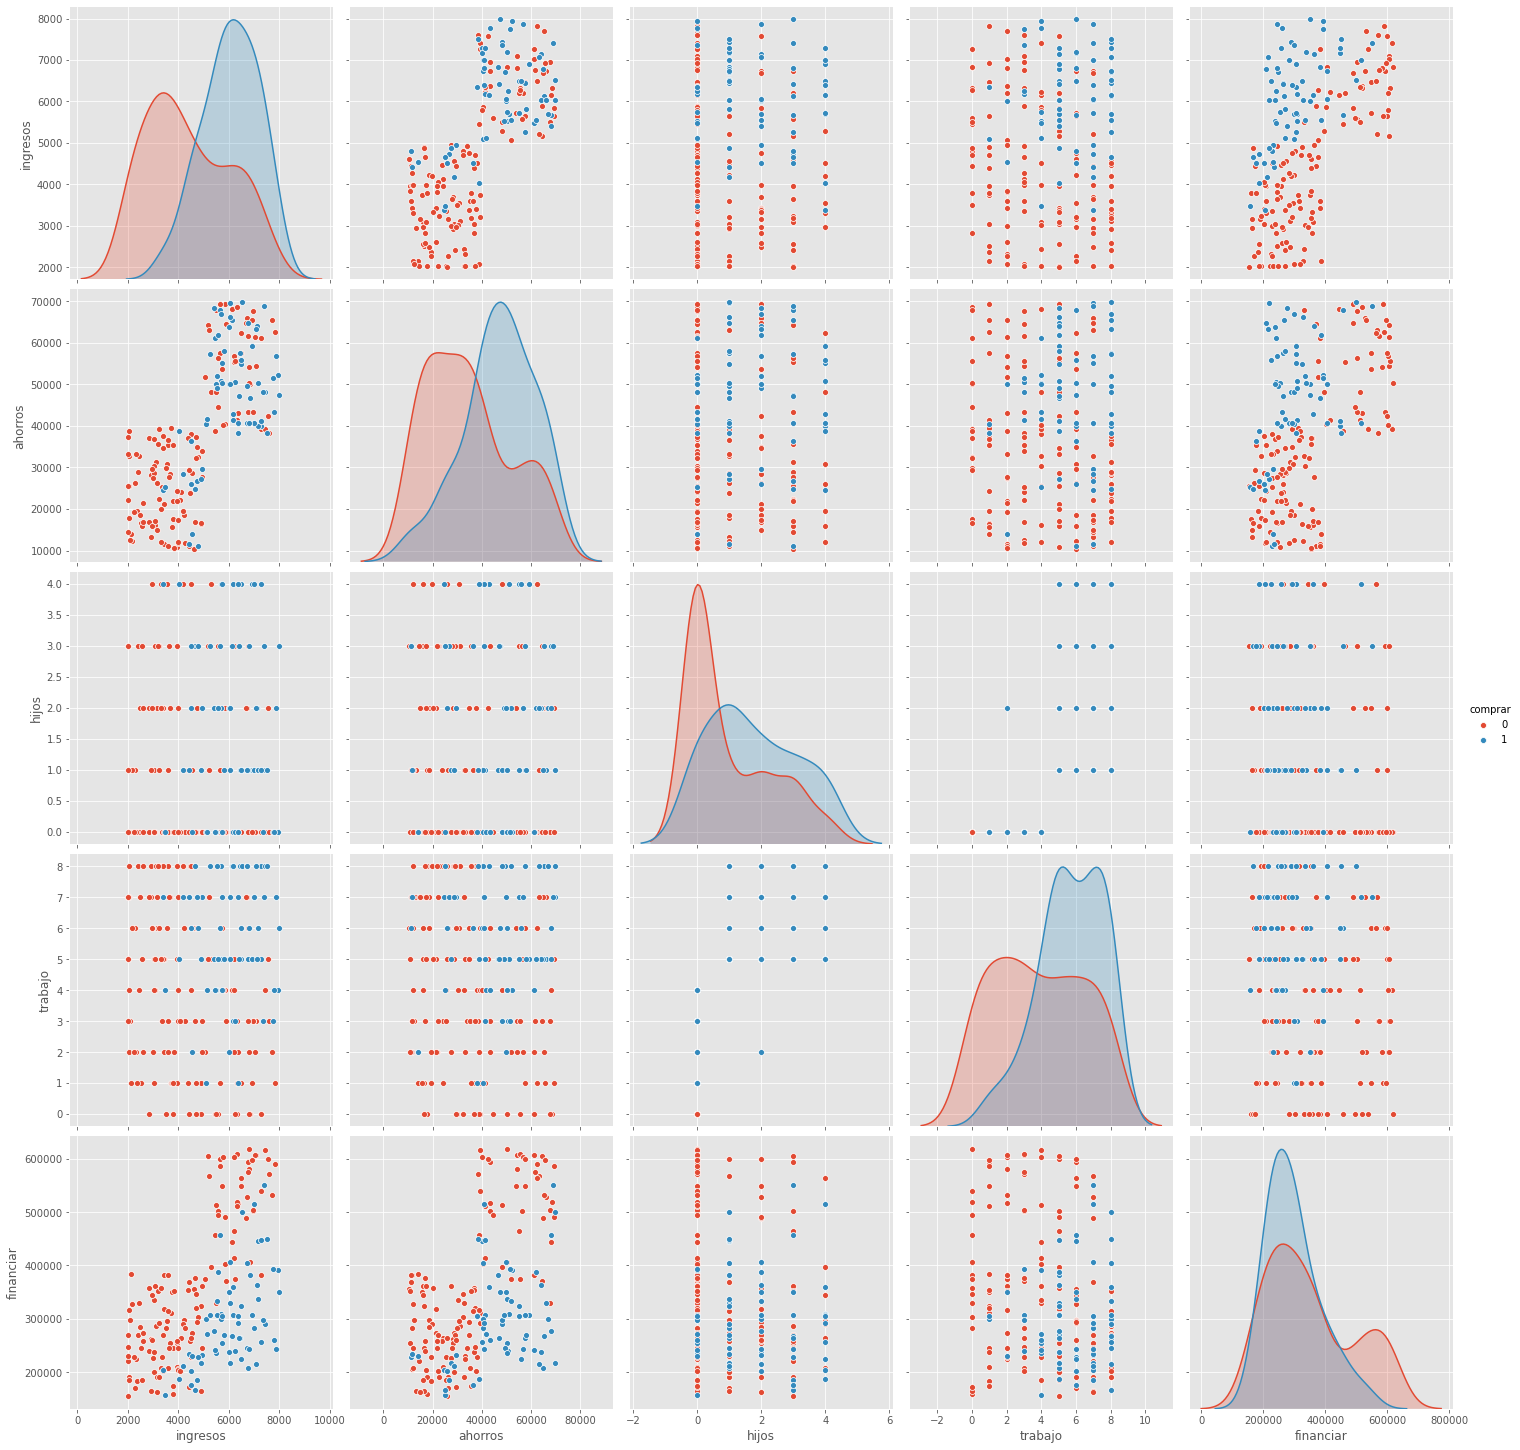

In [17]:
sb.pairplot(dataframe, hue='comprar',size=4,vars=used_features,kind='scatter')

[(100000.0, 700000.0), (2000.0, 9000.0)]

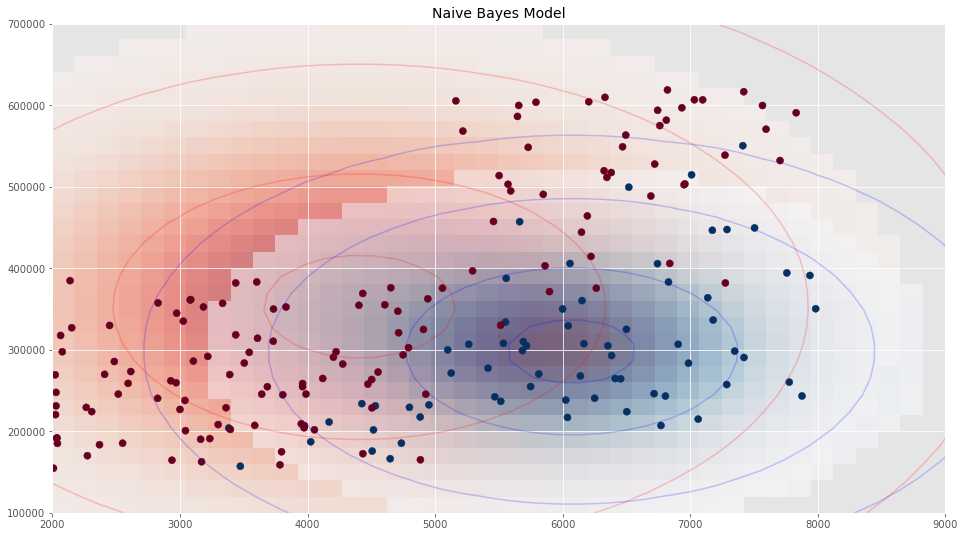

In [18]:
used_features2 =[
    "ingresos",
    "financiar"
]
X=dataframe[used_features2].values
y=dataframe["comprar"]

fig, ax = plt.subplots()

ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (2000, 9000)
ylim = (100000, 700000)

xg = np.linspace(xlim[0], xlim[1], 40)
yg = np.linspace(ylim[0], ylim[1], 30)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)